## Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ssl
from bs4 import BeautifulSoup 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score,
                             roc_curve, precision_recall_fscore_support)
from imblearn.over_sampling import SMOTE

# --- FIX: SSL and NLTK Downloads ---
# Solves potential connection errors when downloading NLTK data
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("Downloading NLTK resources...")
nltk.download('punkt')
nltk.download('punkt_tab')  # Essential for newer NLTK versions
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("Setup completed successfully.")

# Set visualization style
sns.set(style='whitegrid')

Setup completed successfully.


[nltk_data] Downloading package punkt to /home/mdvr0480/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mdvr0480/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mdvr0480/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mdvr0480/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mdvr0480/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2: Load Data and Basic EDA

Dataset loaded. Initial Shape: (17880, 18)
Converting target labels to integers...
Duplicates removed: 235
Unused columns dropped. Keeping: ['title', 'company_profile', 'description', 'requirements', 'fraudulent']

Missing values before handling:
 title                 0
company_profile    3287
description           0
requirements       2650
fraudulent            0
dtype: int64
Missing values after handling:
 title              0
company_profile    0
description        0
requirements       0
fraudulent         0
dtype: int64
Final Dataset Shape: (17645, 5)


/tmp/ipykernel_8695/4290897945.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='coolwarm')


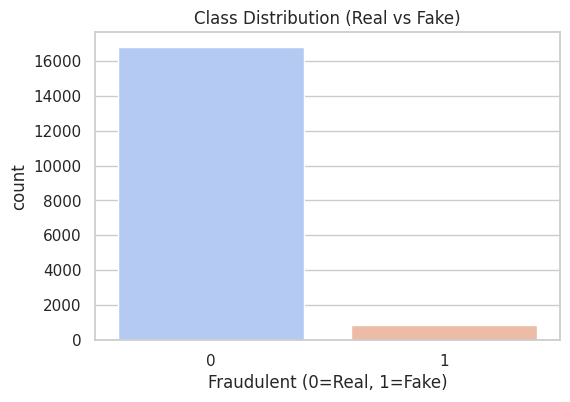

Fraud Ratio: 0.0511


In [ ]:
# 1. Load the Dataset
try:
    df = pd.read_csv('DataSet.csv')
    print(f"Dataset loaded. Initial Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'DataSet.csv' not found. Please upload the file.")

# 2. Fix Target Labels (Convert 't'/'f' to 1/0)
# This prevents errors in Scikit-Learn functions later
if df['fraudulent'].dtype == 'object':
    print("Converting target labels to integers...")
    df['fraudulent'] = df['fraudulent'].map({'t': 1, 'f': 0})

# 3. Requirement: Remove Duplicates
initial_count = len(df)
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_count - len(df)}")

# 4. Requirement: Remove Unused Columns
# We only need text features and the target variable. Dropping ID or metadata columns.
relevant_cols = ['title', 'company_profile', 'description', 'requirements', 'fraudulent']
df = df[relevant_cols]
print(f"Unused columns dropped. Keeping: {relevant_cols}")

# 5. Requirement: Handle Missing Values
print("\nMissing values before handling:\n", df.isnull().sum())

# Strategy: 
# - 'description' is the most critical feature. If it's missing, the row is useless. Drop it.
# - For other text columns (like company_profile), we fill with an empty string.
df.dropna(subset=['description'], inplace=True)
df.fillna('', inplace=True)

print("Missing values after handling:\n", df.isnull().sum())
print(f"Final Dataset Shape: {df.shape}")

# 6. Visualize Class Distribution (Imbalance Check)
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df, palette='coolwarm')
plt.title('Class Distribution (Real vs Fake)')
plt.xlabel('Fraudulent (0=Real, 1=Fake)')
plt.show()

# Calculate Fraud Ratio
class_counts = df['fraudulent'].value_counts()
print(f"Fraud Ratio: {class_counts[1] / class_counts[0]:.4f}")

## 3: Advanced Text Preprocessing
### Initialize tools

In [3]:
# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_cleaning(text):
    """
    Cleans text by removing HTML, replacing specific patterns (Email, URL, Money),
    and applying lemmatization.
    """
    if not isinstance(text, str):
        return ""
        
    # 1. Remove HTML tags (using BeautifulSoup)
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ") 
    
    # 2. Feature Engineering: Replace patterns with tokens
    # This helps the model identify fraud patterns (e.g., asking for money or private emails)
    text = re.sub(r'http\S+|www\.\S+', ' _URL_ ', text)
    text = re.sub(r'\S+@\S+', ' _EMAIL_ ', text)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', ' _PHONE_ ', text)
    text = re.sub(r'[\$€£]\d+|\d+[\$€£]', ' _MONEY_ ', text)
    
    # 3. Normalize: Lowercase & Remove non-letters
    text = re.sub(r'[^a-zA-Z_]', ' ', text).lower()
    
    # 4. Tokenize & Lemmatize
    tokens = word_tokenize(text)
    cleaned_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    
    return ' '.join(cleaned_tokens)

# Combine relevant text columns into one feature
print("Combining text columns...")
df['text_combined'] = (df['title'] + ' ' + df['company_profile'] + ' ' + 
                       df['description'] + ' ' + df['requirements'])

# Apply the cleaning function (This may take a minute)
print("Applying advanced preprocessing...")
df['cleaned_text'] = df['text_combined'].apply(advanced_cleaning)
print("Preprocessing completed.")

Combining text columns...
Applying advanced preprocessing...
Preprocessing completed.


## 4: Vectorization

### Using TF-IDF with Unigrams and Bigrams

In [4]:
# Using TF-IDF with Unigrams and Bigrams
# Bigrams help capture context (e.g., "wire transfer")
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit features to prevent high memory usage
    ngram_range=(1, 2), # Use single words and pairs of words
    min_df=5,           # Ignore very rare words
    max_df=0.95         # Ignore very common words
)

print("Vectorizing text (TF-IDF)...")
X = tfidf.fit_transform(df['cleaned_text'])
y = df['fraudulent']

print(f"Feature Matrix Shape: {X.shape}")

Vectorizing text (TF-IDF)...
Feature Matrix Shape: (17645, 5000)


## 5: Train-Test Split & SMOTE
### Split data (Stratified to maintain class ratio)

In [5]:
# 1. Split Data
# Stratify ensures the fraud ratio is preserved in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Original Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# 2. Requirement: Handle Imbalance (SMOTE)
# Apply SMOTE *only* on Training data to prevent data leakage
print("Applying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Train Class Distribution (Before SMOTE):\n", y_train.value_counts())
print("Train Class Distribution (After SMOTE):\n", y_train_resampled.value_counts())

Original Train shape: (12351, 5000)
Test shape: (5294, 5000)
Applying SMOTE to handle class imbalance...
Train Class Distribution (Before SMOTE):
 fraudulent
0    11750
1      601
Name: count, dtype: int64
Train Class Distribution (After SMOTE):
 fraudulent
0    11750
1    11750
Name: count, dtype: int64


## 6: Model Training

### 1. SVM Classifier

In [6]:
# Model 1: Support Vector Machine (SVM)
print("\nTraining SVM (Linear Kernel)...")
# Linear kernel works best for high-dimensional text data
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)
print("SVM Trained.")

# Model 2: K-Nearest Neighbors (KNN)
print("\nTraining KNN (k=5)...")
# Distance weights give more importance to closer neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test)
print("KNN Trained.")


Training SVM (Linear Kernel)...
SVM Trained.

Training KNN (k=5)...
KNN Trained.


## 7: Evaluation Metrics


>>> Evaluation for SVM <<<


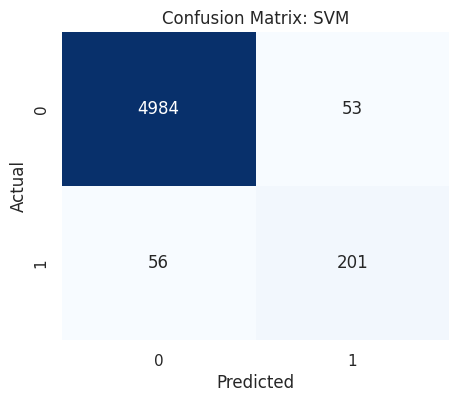

Accuracy:    0.9794
Error Rate:  0.0206
Sensitivity (Recall): 0.7821
Specificity: 0.9895
Precision:   0.7913
F1-Score:    0.7867
False Negatives (Missed Fraud): 56
------------------------------

>>> Evaluation for KNN <<<


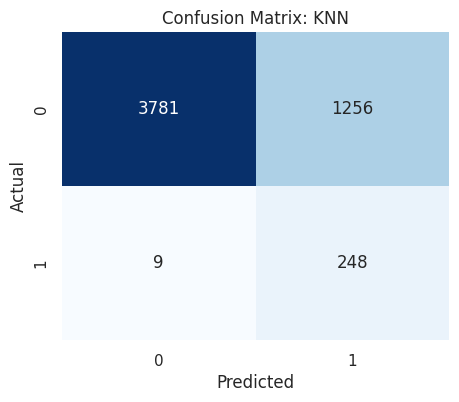

Accuracy:    0.7611
Error Rate:  0.2389
Sensitivity (Recall): 0.9650
Specificity: 0.7506
Precision:   0.1649
F1-Score:    0.2817
False Negatives (Missed Fraud): 9
------------------------------


In [7]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n>>> Evaluation for {model_name} <<<")
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # 2. Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    # Requirement: Specificity (True Negative Rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    
    # Requirement: Error Rate
    error_rate = 1 - acc 
    
    print(f"Accuracy:    {acc:.4f}")
    print(f"Error Rate:  {error_rate:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"False Negatives (Missed Fraud): {fn}")
    print("-" * 30)

# Evaluate both models
evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_knn, "KNN")

## 8: ROC-AUC Curve

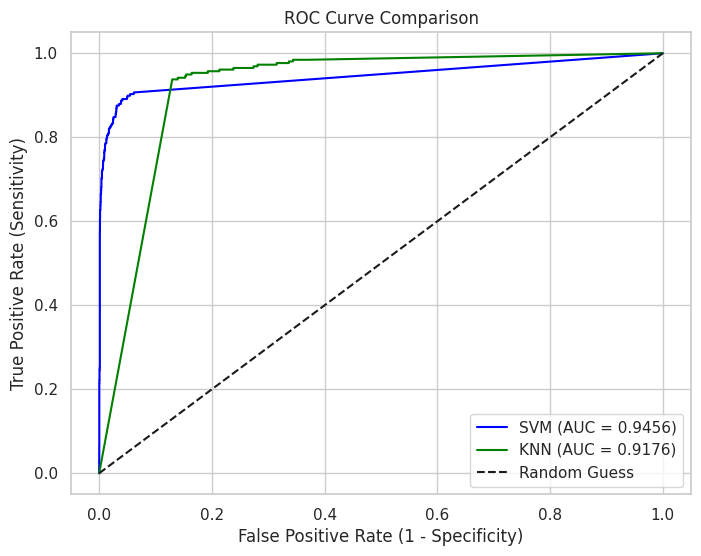

SVM AUC: 0.9456
KNN AUC: 0.9176


In [8]:
# Get probability scores for the positive class (Fraud = 1)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# Calculate AUC scores
auc_svm = roc_auc_score(y_test, y_prob_svm)
auc_knn = roc_auc_score(y_test, y_prob_knn)

# Generate ROC curve data
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})', color='blue')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"SVM AUC: {auc_svm:.4f}")
print(f"KNN AUC: {auc_knn:.4f}")